# Ant Colony Optimization algorithm (ACO)

<h4>ACO</h4>
<img src="https://image.slidesharecdn.com/antcolonyoptimization-120221190648-phpapp02/95/ant-colony-optimization-7-728.jpg?cb=1329853247">

<h4>ACO pseudocode</h4>
<img src="https://www.researchgate.net/profile/D_Nagesh_Kumar/publication/28600558/figure/fig1/AS:309983502716949@1450917234786/Pseudo-code-for-the-Ant-Colony-System-ACS-algorithm.png">


In [1]:
## 載入Library
import pandas as pd
import numpy as np
import sys
import time


In [2]:
'''ACO parameter'''
#資料集名稱
dataset_name = 'dataset/iris.data'
hasAns = True
#分群數
cluster_num = 3
#螞蟻數量
ants_num = 20
#學習參數 α
alpha = 1.0
#學習參數 β
beta = 2
#揮發係數 ρ
rho = 0.02
#最小費洛值/起始費洛蒙
minPheromones = 0.000167
#回合數
run_num = 1
#迭代數
iteration_num = 30


'''資料集分析'''
#讀取資料集
dataset = pd.read_csv(dataset_name , header=None)
### Note dataset[col][row]
#資料集資料筆數
instance_num= dataset.shape[0]
#資料維度
if hasAns:
    dim_num = dataset.shape[1] - 1
else:
    dim_num = dataset.shape[1]
#解
#ants_pass =pd.DataFrame()
ants_pass=np.array([])
#解的形心
ants_centroid=np.array([])
#解的資訊
ants_detail=np.array([])
'''計算輔助'''
#費洛蒙表 pheromones_table[Instance][Cluster]
pheromones_table = np.full((instance_num,cluster_num),minPheromones)
#transferProbability = np.zeros((cluster_num,3))

'''Output'''
BestSol = pd.DataFrame()
BestSSE = sys.float_info.max

Output_SSE=np.zeros((run_num,iteration_num))



In [3]:
def rollDice():
    return np.random.ranf()

In [4]:
def getCentroid(indicate):
    solution = ants_pass[indicate]
    centroid = pd.DataFrame(0.0,index=range(cluster_num),columns=range(dim_num))
    centroid_point_num = pd.DataFrame(0,index=['num'],columns=range(cluster_num))
    ### Note centroid[dim][cluster]
    
    counts=0
    for x in solution:
        centroid_point_num[x]['num'] +=1
        for y in range(dim_num):
            centroid[y][x] += dataset[y][counts]
        counts+=1
    
    for x in range(cluster_num):
        for y in range(dim_num):
            centroid[y][x] /= centroid_point_num[x]['num']
    
    return centroid.values

In [5]:
## getALLCentroid
def getALLCentroid():
    res = getCentroid(0)
    for x in range(1,ants_num):
        temp=getCentroid(x)
        #res = pd.concat([res,temp],axis=1,ignore_index=True)
        res=np.append(res, temp, axis=0)
    res=res.reshape(ants_num,cluster_num,dim_num)
    return res

In [6]:
## getDistance
def getDistance(indicate):
    solution = ants_pass[indicate]
    centroid = ants_centroid[indicate]
    count=0
    distance = 0.0
    for x in solution:
        temp=0.0
        for y in range(dim_num):
            temp += pow(dataset[y][count]-centroid[x][y],2)
        distance += pow(temp,0.5)
        count +=1
    return distance

In [7]:
## getSSE
def getSSE(indicate):
    solution = ants_pass[indicate]
    centroid = ants_centroid[indicate]
    count=0
    SSE = 0.0
    for x in solution:
        for y in range(dim_num):
            SSE += pow(dataset[y][count]-centroid[x][y],2)
        count +=1
    return SSE

In [8]:
#getALLDetail
def getALLDetail():
    # res[Distance][SSE][Pheromones]
    res = np.zeros((ants_num,3))
    for i in range(ants_num):
        res[i][0] = getDistance(i)
        res[i][1] = getSSE(i)
        res[i][2] = 1/res[i][0]
    return res

In [9]:
# get point2centroidDistance
def p2cDistance(ants,point,cluster):
    distance = 0.0
    datapoint=dataset.loc[point]
    centroid_temp=ants_centroid[ants][cluster]
    for x in range(dim_num):
        distance += pow(centroid_temp[x]-datapoint[x],2)
    
    return pow(distance,0.5)

In [10]:
def findBestSol():
    global BestSol
    global BestSSE
    temp=pd.DataFrame(ants_detail)
    localbest = temp[1].idxmin()
    localbest_val = temp[1].min()
    
    if BestSSE >= localbest_val:
        BestSSE = localbest_val
        BestSol=ants_pass[localbest]

In [11]:
'''init'''
def init():
    #根據螞蟻數量與資料集大小 "隨機"產生結果
    global ants_pass
    global ants_centroid
    global ants_detail
    global pheromones_table
    #ants_pass = pd.DataFrame(np.random.choice(cluster_num, size=(ants_num,instance_num)))
    ants_pass=np.random.randint(cluster_num, size=(ants_num,instance_num))
    ### Note: dataset[dim][instance]
    ants_centroid=getALLCentroid()
    pheromones_table = np.full((instance_num,cluster_num),minPheromones)

In [12]:
'''SolutionConstruct'''
def SolutionConstruct():
    #TODO
    global ants_pass
    global ants_centroid
    global ants_detail
    global pheromones_table

    for x in range(ants_num):
        for y in range(instance_num):
            sum_P = 0.0
            sum_roll = 0.0
            transferProbability = np.zeros((cluster_num, 3))
            
            for z in range(cluster_num):
                distance_tmp = p2cDistance(x,y,z)
                if distance_tmp == 0:
                    transferProbability[z][0] = pow(pheromones_table[y][z], alpha) * sys.maxint
                else:
                    transferProbability[z][0] = pow(pheromones_table[y][z], alpha) * pow(1/distance_tmp, beta)
                sum_P += transferProbability[z][0]
        
            for z in range(cluster_num):
                transferProbability[z][1] = transferProbability[z][0]/sum_P
                sum_roll += transferProbability[z][1]
                transferProbability[z][2] = sum_roll

            temp_roll = rollDice()
            select_cluster = -1
            for z in range(cluster_num):
                if temp_roll <= transferProbability[z][2]:
                    select_cluster = z
                    break
            ants_pass[x][y] = select_cluster
            

In [13]:
'''PheromonesUpdate'''
def PheromonesUpdate():
    #TODO
    global ants_pass
    global ants_centroid
    global ants_detail
    global pheromones_table
    
    ants_centroid = getALLCentroid()
    ants_detail = np.array([])
    ants_detail = getALLDetail()
    
    for x in range(instance_num):
        for y in range(cluster_num):
            pheromones_table[x][y] = (1-rho)*pheromones_table[x][y]
            
    for x in range(ants_num):
        for y in range(instance_num):
            temp_sol = ants_pass[x]
            pheromones_table[y][temp_sol[y]] += rho*ants_detail[x][2]


In [14]:

# main function
if __name__ == '__main__':
    tStart = time.time()
    for run in range(run_num):
        init()
        for iteration in range(iteration_num):
            SolutionConstruct()
            PheromonesUpdate()
            findBestSol()
            Output_SSE[run][iteration] = BestSSE
            print (str(BestSSE)+"\n")
    tEnd = time.time()
    print ("It costs "+str(tEnd-tStart)+" sec")
            
 

582.7367125621594

424.18261623609965

289.5079761965183

231.3019967793878

200.38192099792093

171.342765866209

159.2281234629444

141.22706757931334

116.26751758843092

113.98194314944301

113.98194314944301

92.73373083778978

92.73373083778978

92.73373083778978

92.73373083778978

84.37640000000003

84.37640000000003

84.37640000000003

84.37640000000003

84.37640000000003

84.37640000000003

84.37640000000003

84.37640000000003

84.37640000000003

83.16953965586234

83.16953965586234

83.16953965586234

83.16953965586234

83.16953965586234

83.16953965586234

It costs 118.39040946960449 sec


In [15]:
import matplotlib.pyplot as plt

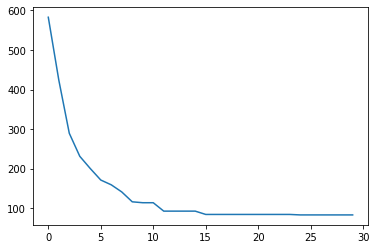

In [16]:
iteration_array=np.arange(30)
plt.plot(iteration_array,Output_SSE[0])
plt.show()